In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir('/content/drive/MyDrive/ml4qs/')

In [3]:
!pip install optuna
!pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import optuna

In [6]:
# Load the dataset
full_data = pd.read_parquet("full_dataset.parquet.gzip")

In [7]:
# Split the dataset into training and testing sets
random.seed(51)
testing_categories = [1, 2, 3, 4, 5, 6]
random.shuffle(testing_categories)

testing_set = [f"{platform}{number}" for platform, number in zip(full_data["SM_platform"].unique(), testing_categories)]
testing_df = full_data[full_data["source_name"].isin(testing_set)]
training_df = full_data[~full_data["source_name"].isin(testing_set)]


In [8]:
# Only select standardized columns
columns_to_select = [col for col in full_data.columns if 'zscore' in col] + ["SM_platform", "index"] + [col for col in
                                                                                                        full_data.columns
                                                                                                        if 'pc' in col]
training_df = training_df.loc[:, columns_to_select]
testing_df = testing_df.loc[:, columns_to_select]


In [9]:
# Separate features and target
X_train = training_df.drop(columns=["SM_platform"])
y_train = training_df["SM_platform"]
X_test = testing_df.drop(columns=["SM_platform"])
y_test = testing_df["SM_platform"]

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
# Create sequences for LSTM
def create_sequences(data, target, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)


sequence_length = 10  # Example sequence length
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_encoded, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_encoded, sequence_length)


In [11]:
# Define the LSTM model
def create_model(trial):
    units = trial.suggest_int('units', 50, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)

    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [12]:
# define Optuna objective function
def objective(trial):
    model = create_model(trial)
    model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    score = model.evaluate(X_test_seq, y_test_seq, verbose=0)
    return score[1]


default training

In [14]:
# Define the LSTM model with default hyperparameters
def create_default_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
# Train the model with default hyperparameters
default_model = create_default_model()
history = default_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
4425/4425 [==============================] - 31s 6ms/step - loss: 0.0270 - accuracy: 0.9921 - val_loss: 11.9349 - val_accuracy: 0.0529
Epoch 2/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0065 - accuracy: 0.9982 - val_loss: 13.8987 - val_accuracy: 0.0293
Epoch 3/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.6766 - val_accuracy: 0.0426
Epoch 4/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 22.0848 - val_accuracy: 0.0117
Epoch 5/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 27.8058 - val_accuracy: 0.0282
Epoch 6/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 30.3497 - val_accuracy: 0.0218
Epoch 7/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 31.3043 -

In [16]:
# Evaluate the model
test_loss, test_accuracy = default_model.evaluate(X_test_seq, y_test_seq)
print(f'Test Accuracy: {test_accuracy:.4f}')


1118/1118 [==============================] - 3s 3ms/step - loss: 15.5960 - accuracy: 0.5352
Test Accuracy: 0.5352


In [17]:
# Predict and generate confusion matrix
y_pred = default_model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)

1118/1118 [==============================] - 3s 2ms/step


In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_seq, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)



Confusion Matrix:
[[5985    1    0    0    0    0]
 [   9 5942    0    0    0    0]
 [   1 5951    3    0    0    0]
 [   0    7    0 5947    1    0]
 [   0    0    1 4695 1259    0]
 [   0    0 5952    3    0    0]]


In [19]:
# Classification Report
class_report = classification_report(y_test_seq, y_pred_classes, target_names=label_encoder.classes_)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          FB       1.00      1.00      1.00      5986
       Insta       0.50      1.00      0.67      5951
         Red       0.00      0.00      0.00      5955
      Reddit       0.56      1.00      0.72      5955
      TikTok       1.00      0.21      0.35      5955
           X       0.00      0.00      0.00      5955

    accuracy                           0.54     35757
   macro avg       0.51      0.53      0.46     35757
weighted avg       0.51      0.54      0.46     35757



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


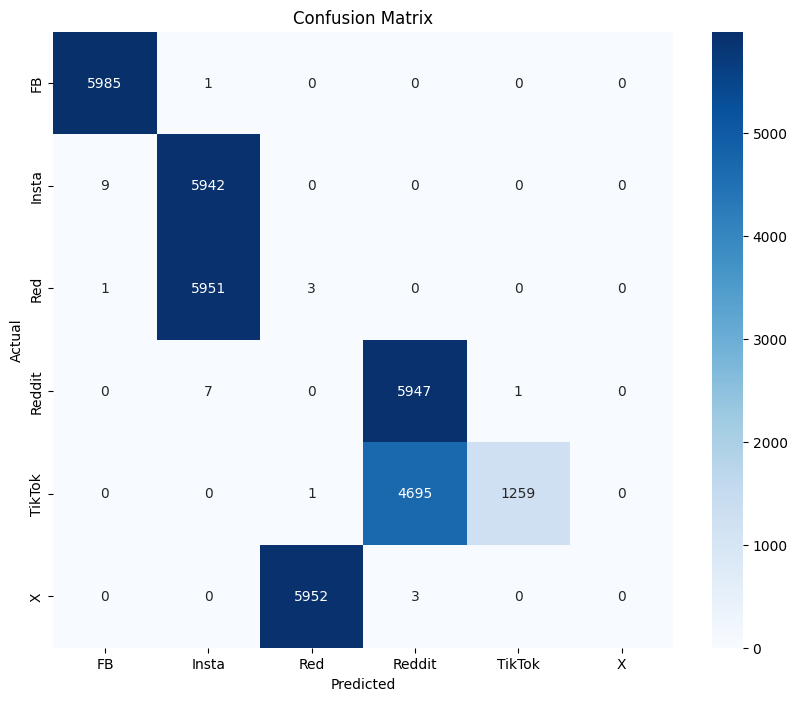

In [20]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

hyperparameter tuning with optuna

In [21]:
# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-06-16 22:55:21,367] A new study created in memory with name: no-name-d09c9bda-590f-4ab1-8e80-67df46c9011b
[I 2024-06-16 22:59:16,723] Trial 0 finished with value: 0.5194507241249084 and parameters: {'units': 85, 'dropout_rate': 0.32503231800869714, 'learning_rate': 0.007505961237819798}. Best is trial 0 with value: 0.5194507241249084.
[I 2024-06-16 23:03:14,853] Trial 1 finished with value: 0.4679643213748932 and parameters: {'units': 141, 'dropout_rate': 0.4876115515472854, 'learning_rate': 0.009332357233078304}. Best is trial 0 with value: 0.5194507241249084.
[I 2024-06-16 23:07:14,688] Trial 2 finished with value: 0.5334619879722595 and parameters: {'units': 149, 'dropout_rate': 0.4786666681263532, 'learning_rate': 0.005989520070976265}. Best is trial 2 with value: 0.5334619879722595.
[I 2024-06-16 23:11:11,950] Trial 3 finished with value: 0.523310124874115 and parameters: {'units': 193, 'dropout_rate': 0.42611975758605714, 'learning_rate': 0.0030119854108813316}. Best is t

In [22]:
# Train the model with the best hyperparameters
best_params = study.best_params
best_model = create_model(optuna.trial.FixedTrial(best_params))
history = best_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
4425/4425 [==============================] - 29s 6ms/step - loss: 0.0665 - accuracy: 0.9792 - val_loss: 36.8887 - val_accuracy: 0.0162
Epoch 2/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0324 - accuracy: 0.9907 - val_loss: 38.0349 - val_accuracy: 0.0373
Epoch 3/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0334 - accuracy: 0.9904 - val_loss: 42.8138 - val_accuracy: 0.0264
Epoch 4/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0357 - accuracy: 0.9893 - val_loss: 55.4409 - val_accuracy: 0.0435
Epoch 5/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0502 - accuracy: 0.9849 - val_loss: 72.7824 - val_accuracy: 0.0429
Epoch 6/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0445 - accuracy: 0.9860 - val_loss: 76.4809 - val_accuracy: 0.0497
Epoch 7/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0512 - accuracy: 0.9839 - val_loss: 78.0191 -

In [23]:
# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test_seq, y_test_seq)
print(f'Test Accuracy: {test_accuracy:.4f}')

1118/1118 [==============================] - 3s 3ms/step - loss: 10.8990 - accuracy: 0.3528
Test Accuracy: 0.3528


In [24]:
# Predict and generate confusion matrix
y_pred = best_model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_seq, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

1118/1118 [==============================] - 3s 2ms/step
Confusion Matrix:
[[4689  576  511  195   15    0]
 [1503 2808  519  976  145    0]
 [ 860 3923  271  400  501    0]
 [ 179  249  640 3497 1390    0]
 [ 265 1106  443 2790 1351    0]
 [ 557  477 2722  784 1415    0]]


In [25]:
# Classification Report
class_report = classification_report(y_test_seq, y_pred_classes, target_names=label_encoder.classes_)
print('Classification Report:')
print(class_report)


Classification Report:
              precision    recall  f1-score   support

          FB       0.58      0.78      0.67      5986
       Insta       0.31      0.47      0.37      5951
         Red       0.05      0.05      0.05      5955
      Reddit       0.40      0.59      0.48      5955
      TikTok       0.28      0.23      0.25      5955
           X       0.00      0.00      0.00      5955

    accuracy                           0.35     35757
   macro avg       0.27      0.35      0.30     35757
weighted avg       0.27      0.35      0.30     35757



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


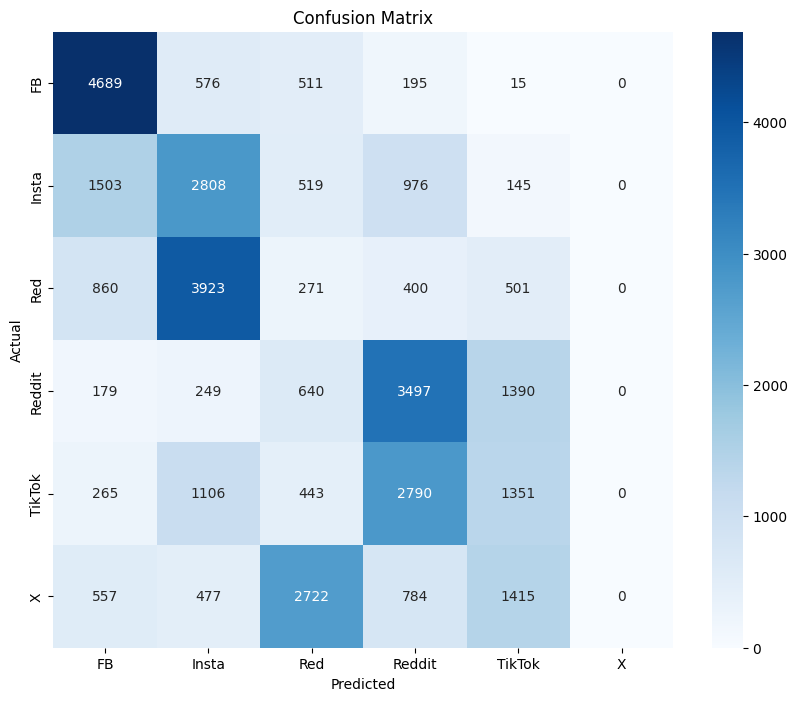

In [26]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()